**Start simulation**

* load network
* load trafficlight logics
* import behaviour from mycity


1. load network

In [1]:
import os
import traci  # Import the TraCI (Traffic Controller Interface) module for interacting with SUMO
if traci.isLoaded():
    traci.close()

NET_FILE = "simulation/V7_landau_small_opt.net.xml"
# Define the path to the SUMO binaries and the network file
SUMO_BIN = os.path.join("C:/", "Program Files (x86)", "Eclipse", "Sumo", "bin", "sumo.exe")
SUMO_GUI_BIN = os.path.join("C:/", "Program Files (x86)", "Eclipse", "Sumo", "bin", "sumo-gui.exe")

traci.start([
    SUMO_GUI_BIN,
    "-n", NET_FILE,
    "-a", "simulation/vehicles.xml",
    #"--gui-settings-file", "simulation/gui_settings_Landau.xml",
    
    #"--start"
])

print("Network loaded successfully")

Network loaded successfully


**load traffic light logic**  using LISA logic or using the signal data for last time (or prediction)


In [2]:
import traci

LABEL = "run1"

# Eğer run1 daha önce açıldıysa kapat
try:
    traci.switch(LABEL)
    traci.close()
except Exception:
    pass

traci.start([
    SUMO_GUI_BIN,
    "-n", NET_FILE,
    "-a", "simulation/vehicles.xml,simulation/flows.xml, simulation/tls_9869.xml,simulation/tls_9873.xml,simulation/tls_9874.xml,simulation/tls_9876.xml,simulation/tls_15293.xml",
    "--gui-settings-file", "simulation/gui_settings_Landau.xml",
    "--start"
], label=LABEL)

traci.switch(LABEL)
print("TLS loaded:", traci.trafficlight.getIDList())

for t in ["9869","9873","9874","9876","15293"]:
    print(t, "program:", traci.trafficlight.getProgram(t))


traci.close()


TLS loaded: ('15226', '15227', '15293', '9864', '9867', '9869', '9870', '9871', '9873', '9874', '9875', '9876', '9886', '9887', '9888', '9897')
9869 program: prog1
9873 program: prog1
9874 program: prog1
9876 program: prog1
15293 program: prog1


**Import behaviour from mycity** current signal program, ???

**Get demand from management system**

* import json / csv
* parse the information

**Distribution of the cars in the network**

**Import from json**

In [21]:
import json, glob, os

folder = r"C:\Users\mogul\OneDrive\Masaüstü\mt_emre\data\Landau\2025-09\LDLSA8"
files = sorted(glob.glob(os.path.join(folder, "*.json")))

with open(files[0], "r", encoding="utf-8") as f:
    data = json.load(f)

print("Top-level keys:", list(data.keys()))
print("timeFrames:", data.get("timeFrames"))


Top-level keys: ['deviceId', 'start', 'end', 'intervalLength', 'tenantId', 'timeFrames']
timeFrames: []


**Using LSTM for making prediction 15Min**

* use router e.g. dfrouter to define the demand for each route
* look for the vehicle type distribution
* have a look for incidents / slower vehicles

**Let the simulation run for 5 minutes (simulation time)**

**Export traffic parameters**

* queue length
* waiting time
* incident / jams


**Get Sumo parameters**

In [ ]:
import os
import traci
from sumolib import checkBinary

NET_FILE = "simulation/V7_landau_small_opt.net.xml"

SUMO_HOME = os.environ.get("SUMO_HOME")
if SUMO_HOME:
    # Uses your SUMO_HOME installation (recommended)
    sumo_binary = checkBinary("sumo")
else:
    # Fallback: your hardcoded path
    sumo_binary = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"

traci.start([
    sumo_binary,
    "-n", NET_FILE,
    "-a", "simulation/vehicles.xml,simulation/flows.xml",  # <-- comma-separated
    "--queue-output", "queue_length.xml",
    "--step-length", "1",
    "--start"
])

for t in range(3600):
    traci.simulationStep()

traci.close()


**read queue length**

In [5]:
import xml.etree.ElementTree as ET

queue_file = "queue_length.xml"

tree = ET.parse(queue_file)
root = tree.getroot()

queue_lengths = []

for data in root.findall("data"):
    for lanes in data.findall("lanes"):
        for lane in lanes.findall("lane"):
            q = float(lane.get("queueing_length", 0))
            queue_lengths.append(q)

print("Total queue observations:", len(queue_lengths))
print("Sample values:", queue_lengths[:10])



Total queue observations: 114845
Sample values: [0.0, 5.0, 5.0, 5.0, 0.0, 5.0, 0.0, 6.01, 5.0, 5.96]


**plot queue length**


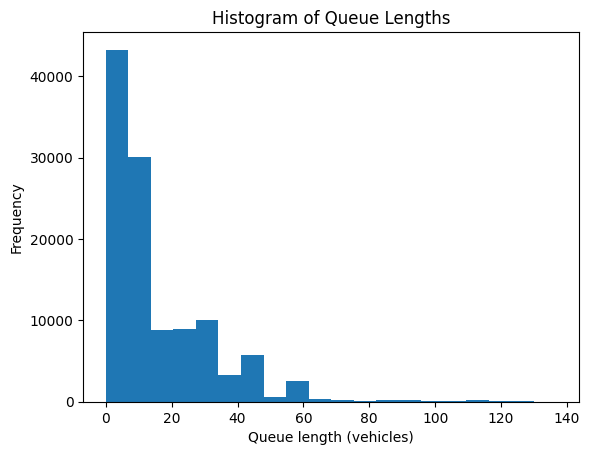

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(queue_lengths, bins=20)
plt.xlabel("Queue length (vehicles)")
plt.ylabel("Frequency")
plt.title("Histogram of Queue Lengths")
plt.show()


**Stop simulation**